<img src=https://www.universidadviu.com/sites/universidadviu.com/themes/custom/universidadviu_com/logo.webp style="height: 100px">
<center style="color:#888">Master en Bigdata y  Data Science<br/>Trabajo Final de Master 2022</center>

## **Identificación de oportunidades de compra en el mercado inmobiliario para alquiler**

**Autor:** Luis Eduardo Rodriguez<br/>
**Módulo:** Modelado/Entrenamiento y Validacio  Alquiler

### **Descripcion:**

En el siguiente libro se hace entrenamiento y validacion de varios modelos MLPR para el set de Alquileres,  Los parametros seleccionados son los del resultado del gridsearchCV (Optimizacion de Hyperparametros), la variable objetivo: Price,  se prueba:

* Usando el scaler  Maxmin
* Aumentando las iteraciones a 3000
* Aumentando el numero de neuronas en el hidden layer
* Eliminando catgoricas

En ningun caso se logra la convergencia.


### **Librerias**

In [48]:
#Cargamos librerias con todo lo necesario.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.metrics import explained_variance_score

### **Carga de Datos**

Se carga la data colectada con Api idealista

In [49]:
#Lectura CSVs  desde directorio data desde donde esta guardado el libro, todos tiene las mismas columnas
df = pd.DataFrame()
for csv_file in Path('.').glob('data/*.csv'):
    df_aux = pd.read_csv(csv_file, index_col=None, header=0)
    df = df.append(df_aux, ignore_index=True, sort=False)
#df inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              9391 non-null   int64  
 1   propertyCode            9391 non-null   int64  
 2   thumbnail               9328 non-null   object 
 3   externalReference       7401 non-null   object 
 4   numPhotos               9391 non-null   int64  
 5   floor                   8427 non-null   object 
 6   price                   9391 non-null   float64
 7   propertyType            9391 non-null   object 
 8   operation               9391 non-null   object 
 9   size                    9391 non-null   float64
 10  exterior                9391 non-null   bool   
 11  rooms                   9391 non-null   int64  
 12  bathrooms               9391 non-null   int64  
 13  address                 9391 non-null   object 
 14  province                9391 non-null   

### **Limpieza de Datos**

Se aplica todos los cambios  del analisis exploratorio

In [50]:
#Eliminación de features innecesarias
dropcolumns = ['Unnamed: 0', 'thumbnail', 'externalReference', 'numPhotos', 'country',
               'hasVideo', 'newDevelopment','suggestedTexts', 'hasPlan', 'has3DTour',
               'has360', 'hasStaging', 'topNewDevelopment', 'labels', 'newDevelopmentFinished',
              'showAddress', 'priceByArea']
df = df.drop(columns=dropcolumns)

#Eliminación de duplicados
df = df.drop_duplicates(subset="url", keep='first')

#transformación de floors a números enteros y redondeamos a 1 decimal
df['floor'] = df['floor'].replace({'en': 0.5, 'bj': 0, 'ss': -0.5, 'st': -1}).astype(float)
df['floor'] = df['floor'].fillna(df['floor'].mean())
df['floor'] = df['floor'].round(decimals = 1)

#variables campos vacios con false.
df['hasLift'] = df['hasLift'].fillna(False)

#remplazamos Nulos por "{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}"
df['parkingSpace'] = df['parkingSpace'].fillna("{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}")

#Convertimos  Parking Space en: hasParkingSpace, isParkingSpaceIncludedInPrice, luego lo removemos
df_aux = df['parkingSpace'].str.split(n=4, expand=True)
df_aux.columns =['h1', 'hasParkingSpace', 'h2', 'isParkingSpaceIncludedInPrice', 'h3']
df_aux['hasParkingSpace'] = df_aux['hasParkingSpace'].replace({'False,': 'False', 'True,': 'True'})
df_aux['isParkingSpaceIncludedInPrice'] = df_aux['isParkingSpaceIncludedInPrice'].replace({'False}': 'False', 'False,': 'False', 'True}': 'True'})
df = pd.concat([df,df_aux[['hasParkingSpace', 'isParkingSpaceIncludedInPrice']]], axis=1).drop(['parkingSpace','isParkingSpaceIncludedInPrice'], axis=1)

# Sustituimos NAN en status por "good"
df['status'] = df['status'].fillna("good")

# Sustituimos NAN en distrito por municipalidades. y en vecindario por distrito
df['district'] = df['district'].fillna(df['municipality'])
df['neighborhood'] = df['neighborhood'].fillna(df['district'])

#Convertimos  detailType en los subgrupos Typology y Subtypology, remplazamos nan  de SubTypology por Typology
df_aux = df['detailedType'].str.split(n=3, expand=True)
df_aux.columns =['h1', 'typology', 'h2', 'subTypology']
df_aux['typology'] = df_aux['typology'].replace({"'chalet',": 'chalet', "'chalet'}": 'chalet',
                                                 "'flat',": 'flat', "'flat'}": 'flat',
                                                 "'countryHouse',": 'countryHouse', "'countryHouse'}": 'countryHouse'})
df_aux['subTypology'] = df_aux['subTypology'].replace({"'casaTerrera'}": 'casaTerrera', "'casale'}": 'casale',
                                                       "'countryHouse'}": 'countryHouse', "'duplex'}": 'duplex',
                                                       "'independantHouse'}": 'independantHouse', "'studio'}": 'studio',
                                                      "'terracedHouse'}": 'terracedHouse', "'penthouse'}": 'penthouse',
                                                      "'semidetachedHouse'}": 'semidetachedHouse'})
df_aux['subTypology'] = df_aux['subTypology'].fillna(df_aux['typology'])

df = pd.concat([df,df_aux[['typology', 'subTypology']]], axis=1).drop(['detailedType','typology'], axis=1)

#Transformamos en variables numéricas  todas  las tipo binario (True or False)
columns = df.loc[: , (df == 'False').any()].columns
for column in columns:
    df[column] = df[column].map({'True': True, 'False': False})
columns = df.select_dtypes('bool').columns
for column in columns:
    df[column] = df[column].astype(float)

#Filtrado de Muestras de barcelona  distance < 5000
df = df[((df['province']=="Barcelona") & (df['distance']<5000)) | (df['province']=="Madrid")]

#Insersion de variable logprice
df['Logprice'] = np.log(df.price.values)

#Quitamos Outlier, para viviendas en venta y alquiler valores obtenidos del analisis exploratorio:
cleaned_df = df[((df['operation']=="rent") & (df['price']<4730)) | (df['operation']=="sale")]
cleaned_df = cleaned_df[((cleaned_df['operation']=="sale") & (cleaned_df['price']<1691000)) | (cleaned_df['operation']=="rent")]

#Quitamos Outlier en el tamaño, en este caso pisos mayores a 296m2
cleaned_df = cleaned_df[cleaned_df['size'] < 296]
#Quitamos Outliers, que vemos que son pisos con más de 9 cuartos
cleaned_df = cleaned_df[cleaned_df['rooms'] <= 9]
#Quitamos Outliers, que vemos que son pisos con más de 5 baños
cleaned_df = cleaned_df[cleaned_df['bathrooms'] <= 5]
#Quitamos Outliers, que vemos que son pisos con más de 13 pisos
cleaned_df = cleaned_df[cleaned_df['floor'] <= 13]

#df  final despues de la limpieza
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     7620 non-null   int64  
 1   floor            7620 non-null   float64
 2   price            7620 non-null   float64
 3   propertyType     7620 non-null   object 
 4   operation        7620 non-null   object 
 5   size             7620 non-null   float64
 6   exterior         7620 non-null   float64
 7   rooms            7620 non-null   int64  
 8   bathrooms        7620 non-null   int64  
 9   address          7620 non-null   object 
 10  province         7620 non-null   object 
 11  municipality     7620 non-null   object 
 12  district         7620 non-null   object 
 13  neighborhood     7620 non-null   object 
 14  latitude         7620 non-null   float64
 15  longitude        7620 non-null   float64
 16  url              7620 non-null   object 
 17  distance      

In [51]:
cleaned_df.columns

Index(['propertyCode', 'floor', 'price', 'propertyType', 'operation', 'size',
       'exterior', 'rooms', 'bathrooms', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'distance',
       'description', 'status', 'hasLift', 'hasParkingSpace', 'subTypology',
       'Logprice'],
      dtype='object')

### **Separamos Datos de Ventas y Alquiler**

In [52]:
#separamos el dataset por los dos tipos de operación y borramos la etiqueta, para este modulo solo trabajos con alquiler

df_rent = cleaned_df[cleaned_df['operation']== 'rent']
df_rent = df_rent.drop('operation', axis=1)

df_sale = cleaned_df[cleaned_df['operation']== 'sale']
df_sale = df_sale.drop('operation', axis=1)

### Datos Sinteticos
Creamos una variable ProvMunDist concat(Province-Municipality-Distric)   para evitar duplicidades
Calculamos el precio medio del distrito, luego decidimos cual usar

In [54]:
#Creación de Variables sintéticas para agrupar Province|Municipality|District|Neighbourhood

df_rent['pmdistrict'] = df_rent['province'] + '|' + df_rent['municipality'] + '|' +  df_rent['district']
df_sale['pmdistrict'] = df_sale['province'] + '|' + df_sale['municipality'] + '|' +  df_sale['district']

df_rent['pmdneigh'] = df_rent['province'] + '|' + df_rent['municipality'] + '|' +  df_rent['district'] + '|' +  df_rent['neighborhood']
df_sale['pmdneigh'] = df_sale['province'] + '|' + df_sale['municipality'] + '|' +  df_sale['district'] + '|' +  df_sale['neighborhood']

In [55]:
#Creación de variable sintética mean price por provincia y distrito

d_mean = df_rent.groupby('pmdistrict').mean()
d_mean = d_mean.rename(columns={"price": "priced_mean"})

n_mean = df_rent.groupby('pmdneigh').mean()
n_mean = n_mean.rename(columns={"price": "pricen_mean"})

df_rent = pd.merge(df_rent, d_mean['priced_mean'], how='left', left_on='pmdistrict', right_on=d_mean.index)
df_rent = pd.merge(df_rent, n_mean['pricen_mean'], how='left', left_on='pmdneigh', right_on=n_mean.index)

### Funcion para evaluar los resultados del entrenamiento

In [56]:
def print_metrics(model, X_train, y_train, X_test, y_test, predictions, prediction_train, dataset_X, dataset_y):
    
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    r2 = r2_score(predictions, y_test)
    evs = explained_variance_score(predictions, y_test)
    mae_train = mean_absolute_error(y_train,prediction_train)
    mae_test = mean_absolute_error(y_test,predictions)
    # Perform K-Fold CV
    scores = cross_val_score(model, dataset_X, dataset_y, cv=5, scoring='r2')
    
    print("RMSE:                 %f" % (rmse))
    print("R2:                   %f" % (r2))
    print("R2 con cross val:     %f" % (scores.mean()))
    print("Varianza explicada:   %f" % (evs))
    print("MAE_train:            %f" % (mae_train))
    print("MAE_test:             %f" % (mae_test))
    
    fig, axe = plt.subplots(1,2,figsize=(10, 4))
    axe[0].scatter(y_train, prediction_train, alpha=0.2)
    axe[0].plot([y_train.min(), y_train.max()], [prediction_train.min(), prediction_train.max()], "--r", linewidth=2)
    axe[0].set_xlabel("Measured")
    axe[0].set_ylabel("Predicted")
    axe[0].title.set_text("Training Set")
    axe[1].scatter(y_test, predictions, alpha=0.2)
    axe[1].plot([y_test.min(), y_test.max()], [predictions.min(), predictions.max()], "--r", linewidth=2)
    axe[1].set_xlabel("Measured")
    axe[1].set_ylabel("Predicted")
    axe[1].title.set_text("Test Set")
    plt.show()

### Preparamos el entorno

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import SCORERS

import xgboost as xgb
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.neural_network import MLPRegressor
#from yellowbrick.regressor import ResidualsPlot

## MultiLayerPerceptron Test1 MaxScaler

### Regresion Preparation

In [28]:
# Seleccionamos features
features=['floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 
          'hasLift', 'hasParkingSpace', 'propertyType', 'pmdistrict']
rent_df_regresion = df_rent[features]
#sale_df_regresion = df_rent.copy()

In [29]:
#Convertimos estas variables a dummies 
rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['pmdistrict'])
rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['propertyType'])

In [30]:
#convertimos todos estos campos a ENTEROS y rellenamos con False los nulos.

rent_df_regresion['bathrooms'] = rent_df_regresion['bathrooms'].astype(float)
rent_df_regresion['rooms'] = rent_df_regresion['rooms'].astype(float)
rent_df_regresion['distance'] = rent_df_regresion['distance'].astype(float)

In [31]:
#Revisamos el DF preparado

rent_df_regresion.info(verbose=True, show_counts=True)
rent_df_regresion.columns
rent_df_regresion.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 0 to 4235
Data columns (total 139 columns):
 #    Column                                                                     Non-Null Count  Dtype  
---   ------                                                                     --------------  -----  
 0    floor                                                                      4236 non-null   float64
 1    price                                                                      4236 non-null   float64
 2    size                                                                       4236 non-null   float64
 3    exterior                                                                   4236 non-null   float64
 4    rooms                                                                      4236 non-null   float64
 5    bathrooms                                                                  4236 non-null   float64
 6    distance                                      

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace,pmdistrict_Barcelona|Barcelona|Ciutat Vella,...,pmdistrict_Madrid|Tres Cantos|Segunda Fase,pmdistrict_Madrid|Velilla de San Antonio|Velilla de San Antonio,pmdistrict_Madrid|Villaviciosa de Odón|Centro,pmdistrict_Madrid|Villaviciosa de Odón|El Bosque,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio
0,5.0,800.0,45.0,1.0,1.0,1.0,1267.0,1.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,3200.0,210.0,1.0,3.0,3.0,601.0,1.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
2,2.0,1500.0,97.0,0.0,2.0,2.0,2518.0,1.0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
3,5.0,3100.0,220.0,1.0,2.0,3.0,876.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,3.0,2100.0,169.0,1.0,3.0,2.0,667.0,1.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0


### Separamos df en entrenamiento  y test (30%)

In [33]:
from sklearn.model_selection import train_test_split

#En el dataset Y incluimos los datos a predecir, que es el rango de precios
df_y = rent_df_regresion['price']
dataset_y = np.array(df_y)

#En el dataset X borramos la varible a predecir
dataset_X = rent_df_regresion.drop('price', axis=1)

#Usamos RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
#rent_df_regresion_robust = RobustScaler().fit_transform(dataset_X)
rent_df_regresion_robust = MinMaxScaler().fit_transform(dataset_X)

#Generamos los datos de Entrenamiento y Test, al 70 - 30
X_train, X_test, y_train, y_test = train_test_split(rent_df_regresion_robust, dataset_y, test_size=.3, random_state=42)

print(len(X_train))
print(len(X_test))

2965
1271


In [38]:
#Instanciamos el modelo con los mejores HiperParametros
mlpr = MLPRegressor(max_iter= 500, random_state=42) #no se logra converger antes de terminar los epoch  el dset no es optimo para MLP NN
#mlpr = MLPRegressor(activation = 'logistic', alpha = 0.01, hidden_layer_sizes = (200,),
#                    max_iter = 100, solver = 'adam', learning_rate ='constant', random_state=42)


In [39]:
#Entrenamos
mlpr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=3000, random_state=42)

In [36]:
#Calculamos las predicciones
predictions_mlpr_test = mlpr.predict(X_test)
predictions_mlpr_train = mlpr.predict(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

RMSE:                 1380.287914
R2:                   -556292.264028
R2 con cross val:     -2.673956
Varianza explicada:   -169127.392977
MAE_train:            1149.076881
MAE_test:             1151.504812


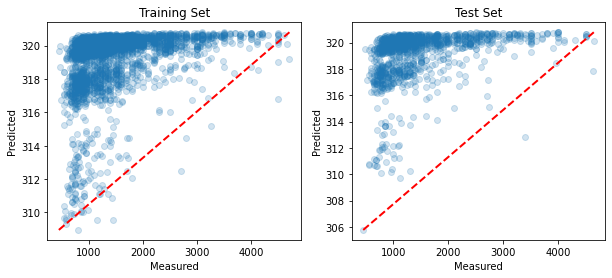

In [37]:
# Revisamos metricas
print_metrics(mlpr, X_train, y_train, X_test, y_test, predictions_mlpr_test, predictions_mlpr_train, dataset_X, dataset_y)

no se logra converger antes de terminar los epoch ni con los valores por defecto u optimizados  por lo que se descarta el modelo

## MultiLayerPerceptron Test2 Usar directamente sin tratar categoricas-> Num

### Regresion Preparation

In [96]:
# Seleccionamos features
features=['floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 
          'hasLift', 'hasParkingSpace', 'propertyType', 'pmdistrict']
rent_df_regresion = df_rent[features]
#sale_df_regresion = df_rent.copy()

In [97]:
#Convertimos estas variables a dummies 
#rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['pmdistrict'])
#rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['propertyType'])

In [98]:
# label encoder 
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()


rent_df_regresion_s = rent_df_regresion.copy()
rent_df_regresion_s['pmdistrict_code'] = lb_make.fit_transform(rent_df_regresion['pmdistrict'])
rent_df_regresion_s['propertyType_code'] = lb_make.fit_transform(rent_df_regresion['propertyType'])
#Eliminamos variables
rent_df_regresion = rent_df_regresion_s.copy()
rent_df_regresion = rent_df_regresion.drop(['propertyType','pmdistrict'], axis=1)


In [99]:
#convertimos todos estos campos a ENTEROS y rellenamos con False los nulos.

rent_df_regresion['bathrooms'] = rent_df_regresion['bathrooms'].astype(float)
rent_df_regresion['rooms'] = rent_df_regresion['rooms'].astype(float)
rent_df_regresion['distance'] = rent_df_regresion['distance'].astype(float)

In [100]:
rent_df_regresion.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace,pmdistrict_code,propertyType_code
0,5.0,800.0,45.0,1.0,1.0,1.0,1267.0,1.0,0.0,63,3
1,1.0,3200.0,210.0,1.0,3.0,3.0,601.0,1.0,0.0,63,3
2,2.0,1500.0,97.0,0.0,2.0,2.0,2518.0,1.0,1.0,65,3
3,5.0,3100.0,220.0,1.0,2.0,3.0,876.0,1.0,1.0,63,2
4,3.0,2100.0,169.0,1.0,3.0,2.0,667.0,1.0,0.0,63,3


### Separamos df en entrenamiento  y test (30%)

In [101]:
from sklearn.model_selection import train_test_split

#En el dataset Y incluimos los datos a predecir, que es el rango de precios
df_y = rent_df_regresion['price']
dataset_y = np.array(df_y)

#En el dataset X borramos la varible a predecir
dataset_X = rent_df_regresion.drop('price', axis=1)

#Usamos RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
#rent_df_regresion_robust = RobustScaler().fit_transform(dataset_X)
rent_df_regresion_robust = MinMaxScaler().fit_transform(dataset_X)

#Generamos los datos de Entrenamiento y Test, al 70 - 30
X_train, X_test, y_train, y_test = train_test_split(rent_df_regresion_robust, dataset_y, test_size=.3, random_state=42)

print(len(X_train))
print(len(X_test))

2965
1271


In [102]:
#Instanciamos el modelo con los mejores HiperParametros
#mlpr = MLPRegressor(max_iter= 500, random_state=42) #no se logra converger antes de terminar los epoch  el dset no es optimo para MLP NN
mlpr = MLPRegressor(max_iter= 500, hidden_layer_sizes= (200,), random_state=42) #probamos una red con numero de neuronas in hidden > numero de cardinalidades 200
#mlpr = MLPRegressor(activation = 'logistic', alpha = 0.01, hidden_layer_sizes = (200,),
#                    max_iter = 100, solver = 'adam', learning_rate ='constant', random_state=42)
mlpr.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (200,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [103]:
#Entrenamos
mlpr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(200,), max_iter=500, random_state=42)

In [36]:
#Calculamos las predicciones
predictions_mlpr_test = mlpr.predict(X_test)
predictions_mlpr_train = mlpr.predict(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

RMSE:                 1380.287914
R2:                   -556292.264028
R2 con cross val:     -2.673956
Varianza explicada:   -169127.392977
MAE_train:            1149.076881
MAE_test:             1151.504812


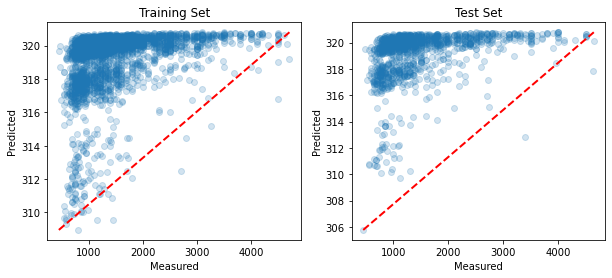

In [37]:
# Revisamos metricas
print_metrics(mlpr, X_train, y_train, X_test, y_test, predictions_mlpr_test, predictions_mlpr_train, dataset_X, dataset_y)

## MultiLayerPerceptron Test3 Se remueve categoricas y  cambiando hidden_layer_sizes

### Regresion Preparation

In [104]:
# Seleccionamos features
features=['floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 
          'hasLift', 'hasParkingSpace']
rent_df_regresion = df_rent[features]
#sale_df_regresion = df_rent.copy()

In [105]:
#Convertimos estas variables a dummies 
#rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['pmdistrict'])
#rent_df_regresion = pd.get_dummies(rent_df_regresion, columns=['propertyType'])

In [98]:
# label encoder 
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()


rent_df_regresion_s = rent_df_regresion.copy()
rent_df_regresion_s['pmdistrict_code'] = lb_make.fit_transform(rent_df_regresion['pmdistrict'])
rent_df_regresion_s['propertyType_code'] = lb_make.fit_transform(rent_df_regresion['propertyType'])
#Eliminamos variables
rent_df_regresion = rent_df_regresion_s.copy()
rent_df_regresion = rent_df_regresion.drop(['propertyType','pmdistrict'], axis=1)


In [106]:
#convertimos todos estos campos a ENTEROS y rellenamos con False los nulos.

rent_df_regresion['bathrooms'] = rent_df_regresion['bathrooms'].astype(float)
rent_df_regresion['rooms'] = rent_df_regresion['rooms'].astype(float)
rent_df_regresion['distance'] = rent_df_regresion['distance'].astype(float)

C:\Users\luis\AppData\Local\Temp/ipykernel_16644/1869564859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_regresion['bathrooms'] = rent_df_regresion['bathrooms'].astype(float)
C:\Users\luis\AppData\Local\Temp/ipykernel_16644/1869564859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_regresion['rooms'] = rent_df_regresion['rooms'].astype(float)
C:\Users\luis\AppData\Local\Temp/ipykernel_16644/1869564859.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [107]:
rent_df_regresion.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace
0,5.0,800.0,45.0,1.0,1.0,1.0,1267.0,1.0,0.0
1,1.0,3200.0,210.0,1.0,3.0,3.0,601.0,1.0,0.0
2,2.0,1500.0,97.0,0.0,2.0,2.0,2518.0,1.0,1.0
3,5.0,3100.0,220.0,1.0,2.0,3.0,876.0,1.0,1.0
4,3.0,2100.0,169.0,1.0,3.0,2.0,667.0,1.0,0.0


### Separamos df en entrenamiento  y test (30%)

In [108]:
from sklearn.model_selection import train_test_split

#En el dataset Y incluimos los datos a predecir, que es el rango de precios
df_y = rent_df_regresion['price']
dataset_y = np.array(df_y)

#En el dataset X borramos la varible a predecir
dataset_X = rent_df_regresion.drop('price', axis=1)

#Usamos RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
#rent_df_regresion_robust = RobustScaler().fit_transform(dataset_X)
rent_df_regresion_robust = MinMaxScaler().fit_transform(dataset_X)

#Generamos los datos de Entrenamiento y Test, al 70 - 30
X_train, X_test, y_train, y_test = train_test_split(rent_df_regresion_robust, dataset_y, test_size=.3, random_state=42)

print(len(X_train))
print(len(X_test))

2965
1271


In [109]:
#Instanciamos el modelo con los mejores HiperParametros
#mlpr = MLPRegressor(max_iter= 500, random_state=42) #no se logra converger antes de terminar los epoch  el dset no es optimo para MLP NN
mlpr = MLPRegressor(max_iter= 500, hidden_layer_sizes= (200,), random_state=42) #probamos una red con numero de neuronas in hidden > numero de cardinalidades 200
#mlpr = MLPRegressor(activation = 'logistic', alpha = 0.01, hidden_layer_sizes = (200,),
#                    max_iter = 100, solver = 'adam', learning_rate ='constant', random_state=42)
mlpr.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (200,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [110]:
#Entrenamos
mlpr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(200,), max_iter=500, random_state=42)

In [36]:
#Calculamos las predicciones
predictions_mlpr_test = mlpr.predict(X_test)
predictions_mlpr_train = mlpr.predict(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

RMSE:                 1380.287914
R2:                   -556292.264028
R2 con cross val:     -2.673956
Varianza explicada:   -169127.392977
MAE_train:            1149.076881
MAE_test:             1151.504812


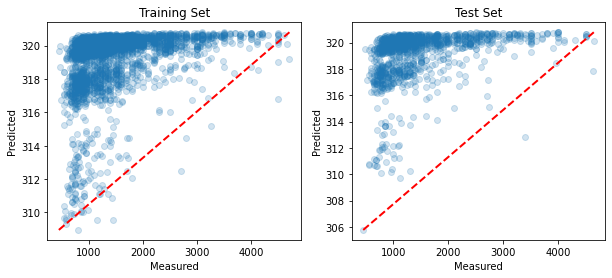

In [37]:
# Revisamos metricas
print_metrics(mlpr, X_train, y_train, X_test, y_test, predictions_mlpr_test, predictions_mlpr_train, dataset_X, dataset_y)